In [1]:
!pip install peft
!pip install evaluate
!pip install transformers
!pip install datasets
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install torch
!pip install adapters

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix , ConfusionMatrixDisplay
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
import torch
from datasets import DatasetDict
from datasets import load_dataset
from adapters import AdapterConfig
from peft import inject_adapter_in_model, LoraConfig
from peft import get_peft_model
from transformers import TrainerCallback
import matplotlib.pyplot as plt
import os
from datasets import load_from_disk

In [4]:
def tokenize_function(examples):
      return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

# Directory to save/load the tokenized dataset
tokenized_dataset_path = "./tokenized_agnews_base"

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=4)

lora_config = LoraConfig(
    r=32,                # Low-rank adaptation dimension
    lora_alpha=128,      # Scaling factor
    lora_dropout=0.2,   # Dropout for LoRA layers
    bias="all",        # Whether to use bias
    task_type="SEQ_CLS", # Task type (sequence classification)
    target_modules=["query", "value"]  # Apply only to key modules

)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

if os.path.exists(tokenized_dataset_path):
    # Load tokenized dataset if it exists
    tokenized_datasets = load_from_disk(tokenized_dataset_path)
    print("Tokenized dataset loaded from disk.")
else:
  dataset = load_dataset("fancyzhx/ag_news")
  tokenized_datasets = dataset.map(tokenize_function, batched=True)
  # Rename 'label' to match Transformers expectations
  tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
  # Remove unnecessary columns
  tokenized_datasets = tokenized_datasets.remove_columns(["text"])
  # Convert datasets to PyTorch format
  tokenized_datasets.set_format("torch")
  # Save tokenized dataset to disk
  tokenized_datasets.save_to_disk(tokenized_dataset_path)
  print("Tokenized dataset saved to disk.")



# Split the dataset
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

small_train_dataset = train_dataset.select(range(1000))


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,875,460 || all params: 126,422,024 || trainable%: 1.4835


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/120000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7600 [00:00<?, ? examples/s]

Tokenized dataset saved to disk.


In [5]:
!cp -r ./tokenized_imdb_base /content/drive/MyDrive/

cp: cannot stat './tokenized_imdb_base': No such file or directory


In [6]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # Get the predicted class by finding the index of the max logit

    # Accuracy
    acc = accuracy_score(labels, preds)

    # Precision, Recall, F1 Score (using macro, micro, or weighted average)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, zero_division=0.0, average="weighted")

    # # Confusion matrix (for multi-class, it returns a matrix)
    # cm = confusion_matrix(labels, preds)

    # Extract True Positives, False Positives, etc. for each class
    # Here, we will return a dictionary with confusion matrix components per class (if needed)
    # tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else (None, None, None, None)

    # For multi-class, it's more useful to look at the entire confusion matrix
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        # 'confusion_matrix': cm.tolist(),  # Return the confusion matrix for more insight
    }


In [7]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",               # Output directory
    run_name="roberta_ag_news_adapter",
    evaluation_strategy="epoch",         # Evaluate every epoch
    learning_rate=5e-5,                  # Learning rate
    per_device_train_batch_size=32,      # Batch size for training
    per_device_eval_batch_size=32,       # Batch size for evaluation
    num_train_epochs=15,                  # Number of epochs
    weight_decay=0.005,                   # Weight decay
    logging_dir="./logs",                # Directory for logs
    logging_steps=200,                   # Log every 500 steps
    save_strategy="epoch",               # Save checkpoints every epoch
    load_best_model_at_end=True,         # Load best model after training
    metric_for_best_model="accuracy",    # Metric to monitor
    lr_scheduler_type="linear",          # Learning rate scheduler tye 4 mins
    # lr_scheduler_type="cosine" ,         # Learning rate scheduler tye  4 mins
    gradient_accumulation_steps=4,    # Gradient accumulation steps.  4 mins with cosine
    fp16=True,  # Enables mixed precision
    # **Debugging Options for CUDA Errors**
    # debug=["underflow_overflow"], # Enable overflow/underflow checks
    # report_to="none",           # Disable reporting to avoid potential conflicts
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
training_logs = []

class CustomCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        logs = logs or {}
        if any(key.startswith("eval_") for key in logs):
            training_logs.append({
                "epoch": state.epoch,
                "loss": logs.get("eval_loss", None),  # Get loss if available, otherwise None
                "accuracy": logs.get("eval_accuracy", None)
            })



trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
    train_dataset=train_dataset,   # Pass the training dataset here
    # train_dataset=small_train_dataset,
    eval_dataset=test_dataset, # Pass the evaluation/validation dataset here
    compute_metrics=compute_metrics
)
trainer.add_callback(CustomCallback)

In [ ]:
trainer.train()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.236300,0.221900,0.923947,0.926092,0.923947,0.923701


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save_pretrained("/content/drive/My Drive/fine_tuned_ag_news_model_with_adapter")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/My Drive/fine_tuned_ag_news_model_with_adapter", num_labels=4)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading adapter weights from /content/drive/My Drive/fine_tuned_ag_news_model_with_adapter led to unexpected keys not found in the model:  ['classifier.modules_to_save.default.modules_to_save.dense.bias', 'classifier.modules_to_save.default.modules_to_save.out_proj.bias', 'classifier.modules_to_save.default.original_module.dense.bias', 'classifier.modules_to_save.default.original_module.out_proj.bias']. 


In [ ]:
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)
conf_matrix = confusion_matrix(test_dataset["labels"], trainer.predict(test_dataset).predictions.argmax(-1))
metrics = trainer.compute_metrics(trainer.predict(test_dataset))


epochs = [log["epoch"] for log in training_logs]
losses = [log["loss"] for log in training_logs]
accuracies = [log["accuracy"] for log in training_logs]

# Smooth accuracies for plotting (fill NaN values)
accuracies = np.array([float(value) if value is not None else np.nan for value in accuracies], dtype=float)
accuracies = np.nan_to_num(accuracies, nan=np.mean(accuracies))  # Replace NaN with the mean of available values


print(training_logs)


Evaluation Results: {'eval_loss': 0.1648438423871994, 'eval_accuracy': 0.9464473684210526, 'eval_precision': 0.9464748491920688, 'eval_recall': 0.9464473684210526, 'eval_f1': 0.9464061263007014, 'eval_runtime': 6.5986, 'eval_samples_per_second': 1151.761, 'eval_steps_per_second': 36.068, 'epoch': 14.992}


[{'epoch': 0.9994666666666666, 'loss': 0.2310633510351181, 'accuracy': 0.9227631578947368}, {'epoch': 2.0, 'loss': 0.19060418009757996, 'accuracy': 0.9372368421052631}, {'epoch': 2.9994666666666667, 'loss': 0.18504758179187775, 'accuracy': 0.9398684210526316}, {'epoch': 4.0, 'loss': 0.17790429294109344, 'accuracy': 0.9403947368421053}, {'epoch': 4.999466666666667, 'loss': 0.18194353580474854, 'accuracy': 0.9413157894736842}, {'epoch': 6.0, 'loss': 0.17364121973514557, 'accuracy': 0.9434210526315789}, {'epoch': 6.999466666666667, 'loss': 0.17804327607154846, 'accuracy': 0.9411842105263157}, {'epoch': 8.0, 'loss': 0.17011237144470215, 'accuracy': 0.9444736842105264}, {'epoch': 8.999466666666667, 'loss': 0.16648244857788086, 'accuracy': 0.944078947368421}, {'epoch': 10.0, 'loss': 0.16673748195171356, 'accuracy': 0.9451315789473684}, {'epoch': 10.999466666666667, 'loss': 0.16649970412254333, 'accuracy': 0.9453947368421053}, {'epoch': 12.0, 'loss': 0.16549557447433472, 'accuracy': 0.9447368

In [ ]:
# Step 7: Plot Loss vs Accuracy


def plot_loss_vs_accuracy(epochs, losses, accuracies):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot loss
    ax1.plot(epochs, losses, 'b-', label="Loss", linewidth=2)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss", color="b")
    ax1.tick_params(axis="y", labelcolor="b")
    ax1.legend(loc="upper left")

    # Normalize accuracy if needed
    if max(accuracies) > 1:  # Assuming accuracy is in percentage
        normalized_accuracies = [acc / 100 for acc in accuracies]
    else:
        normalized_accuracies = accuracies

    # Plot accuracy on a secondary axis
    ax2 = ax1.twinx()
    ax2.plot(epochs, normalized_accuracies, 'r--', label="Accuracy", linewidth=2)
    ax2.set_ylabel("Accuracy", color="r")
    ax2.tick_params(axis="y", labelcolor="r")
    ax2.legend(loc="upper right")

    # Add title and layout adjustments
    plt.title("Loss vs Accuracy Over Epochs")
    fig.tight_layout()
    plt.show()

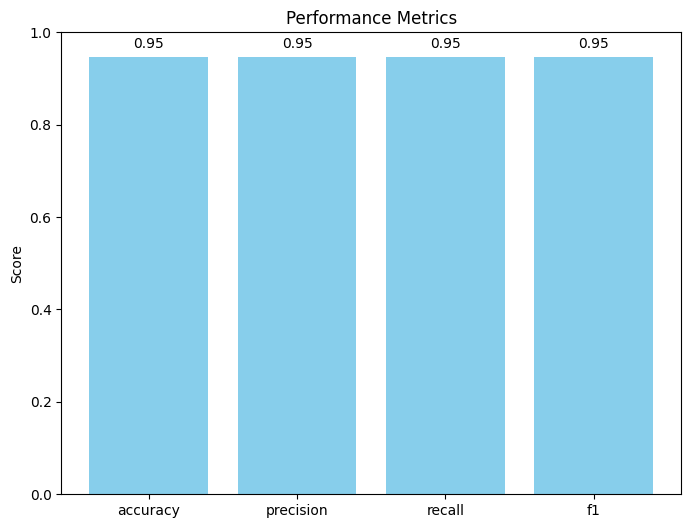

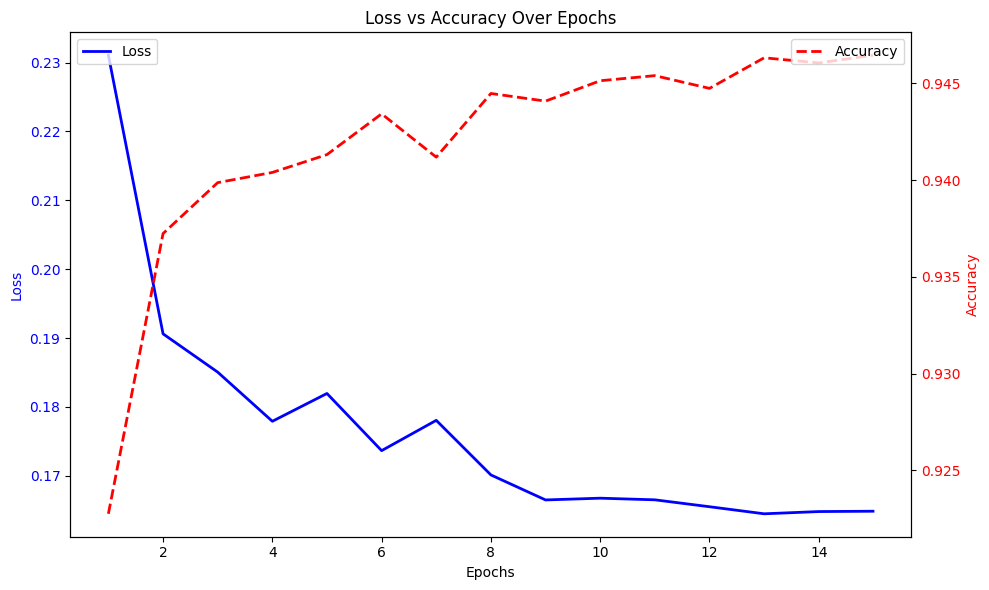

In [ ]:
def plot_metrics(metrics):
    # Metrics to display
    metric_keys = ["accuracy", "precision", "recall", "f1"]
    metric_values = [metrics[key] for key in metric_keys]

    # Plot metrics bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(metric_keys, metric_values, color='skyblue')
    plt.title("Performance Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    for i, value in enumerate(metric_values):
        plt.text(i, value + 0.02, f"{value:.2f}", ha="center", fontsize=10)
    plt.show()

# # Step 8: Plot Confusion Matrix
# def plot_confusion_matrix(conf_matrix):
#     disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
#     disp.plot(cmap="Blues")
#     plt.title("Confusion Matrix")
#     plt.show()

# Call the plotting functions
plot_metrics(metrics)
# plot_confusion_matrix(conf_matrix)
plot_loss_vs_accuracy(epochs, losses, accuracies)
